# 2kr Assumptions Tests (High Density Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

# Fitting
distsFit = ['norm'] # Distributions to fit
distsParams = [()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('msgsPerSlot', 'total number of messages sent (residuals)'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))
    transformations.append((i, lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## Compute residuals

In [9]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# msgsPerSlot
scalars_wide['msgsPerSlotMean'] = scalars_wide.groupby(factors)['Floorplan.msgsPerSlot:sum'].transform('mean')
scalars_wide['msgsPerSlotResidual'] = scalars_wide['Floorplan.msgsPerSlot:sum'] - scalars_wide['msgsPerSlotMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide.groupby(factors)[vecPerfIndex].transform('mean')
    nextVect = False
    for value in mean.values:
        if math.isinf(value):
            skipped.append(vecPerfIndex)
            nextVect = True
            continue
    if nextVect:
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

## Residual distributions (histograms)

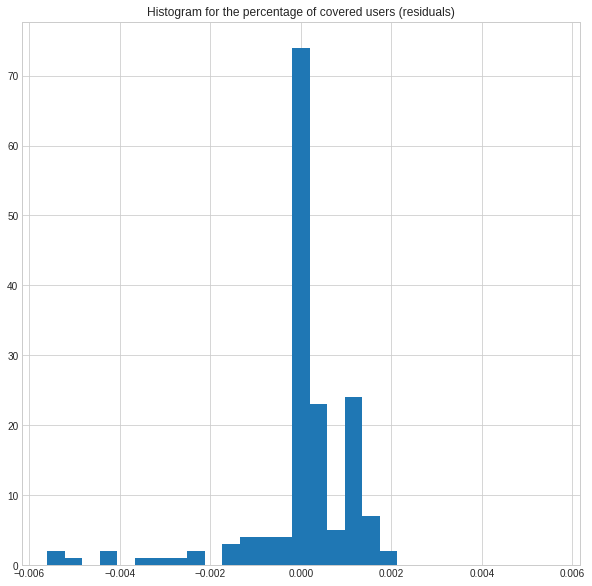

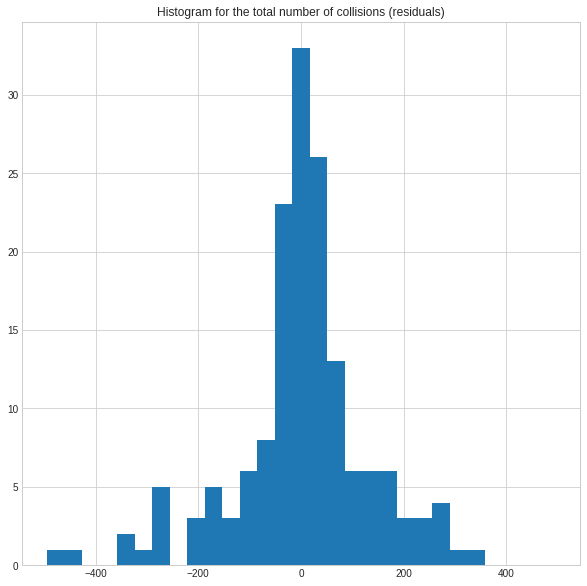

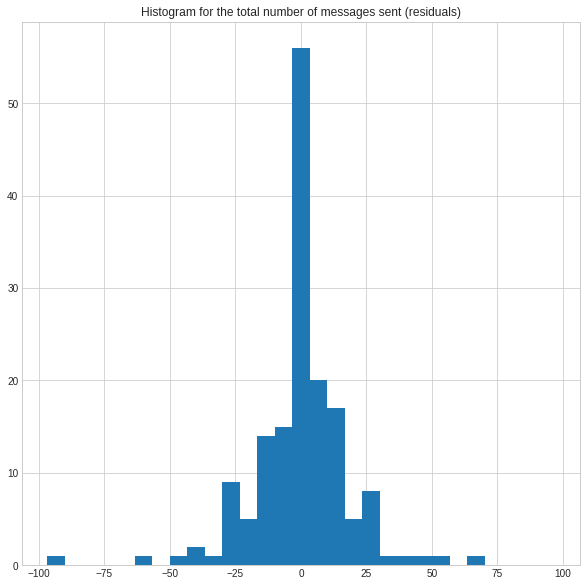

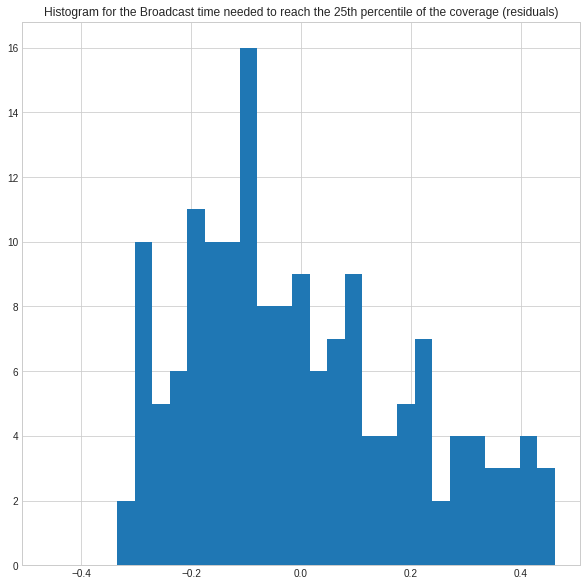

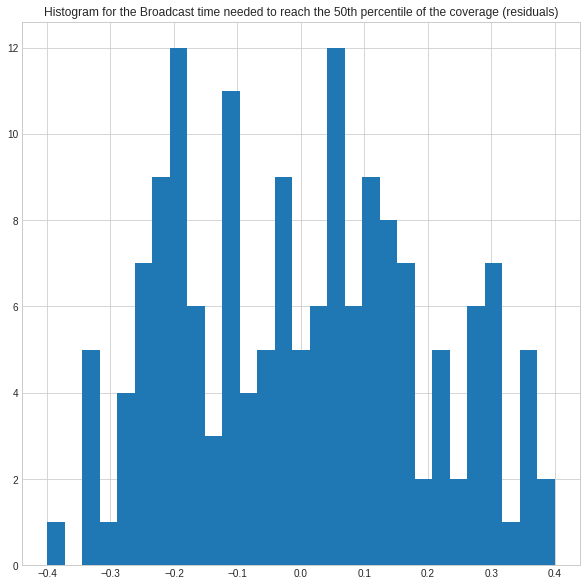

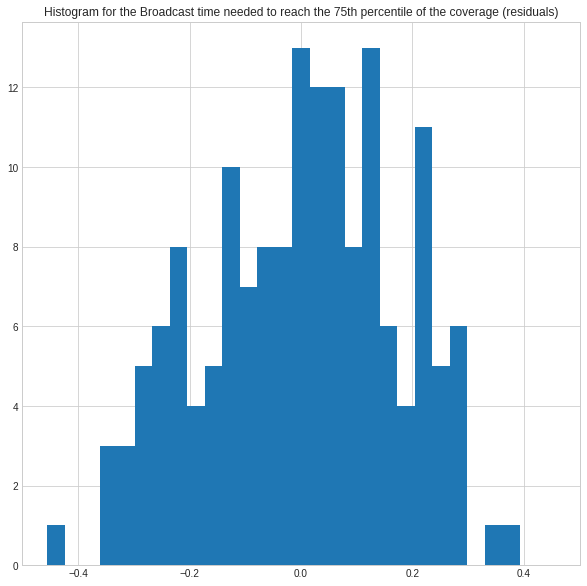

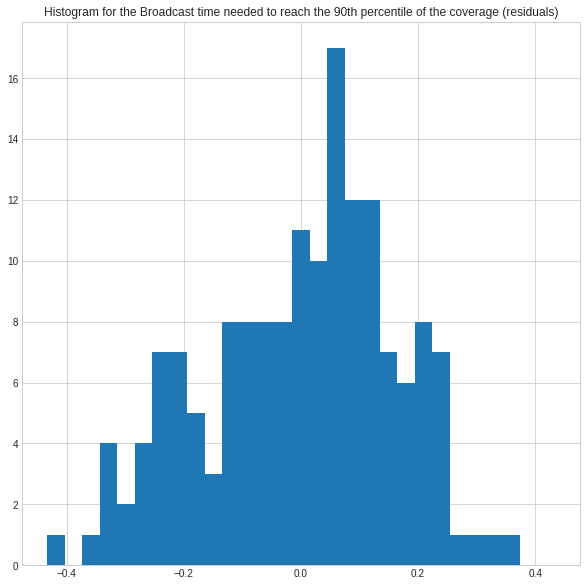

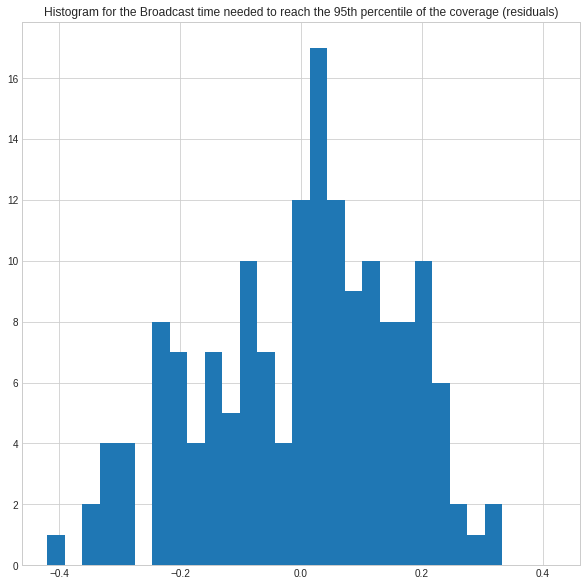

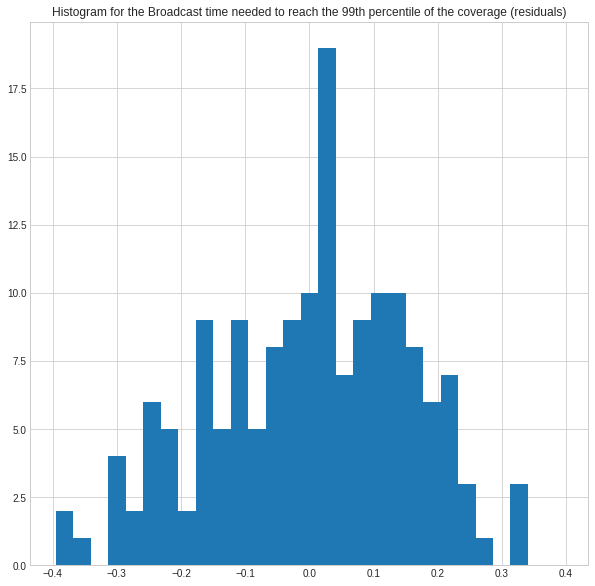

In [10]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-hist.png')
    plt.show()

### Notes on distributions

We can see from histograms that, for all indexes except the percentage of covered users, the distribution of the residuals seems normal. The percentage of covered user has a tail on the left.

## Distribution fitting

Trying to fit to a norm distribution:


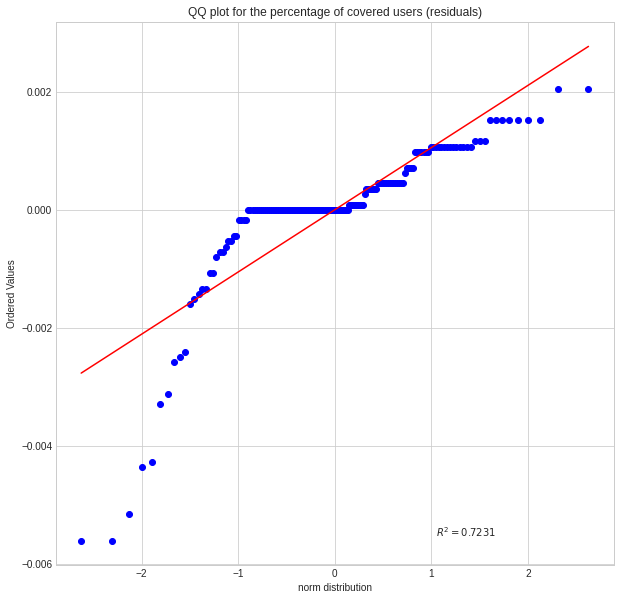

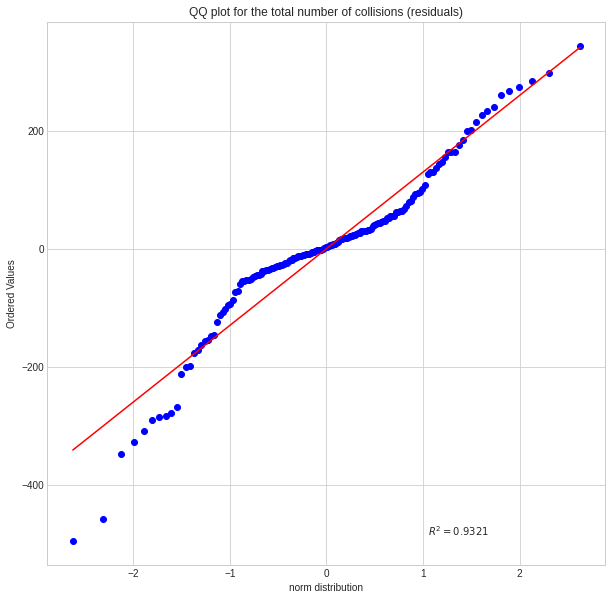

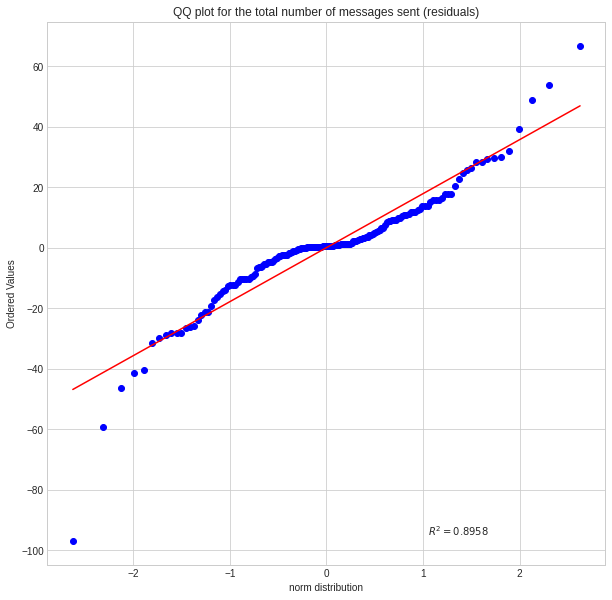

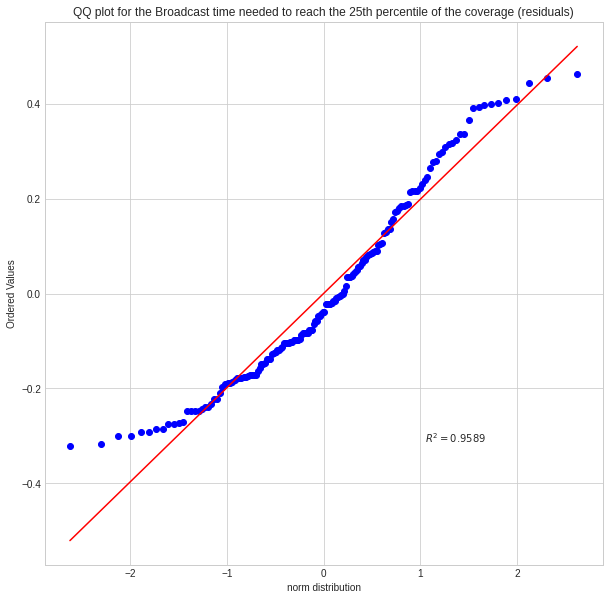

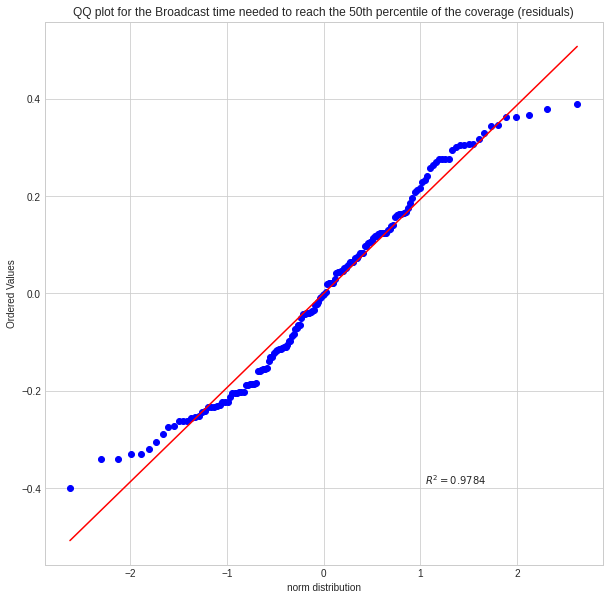

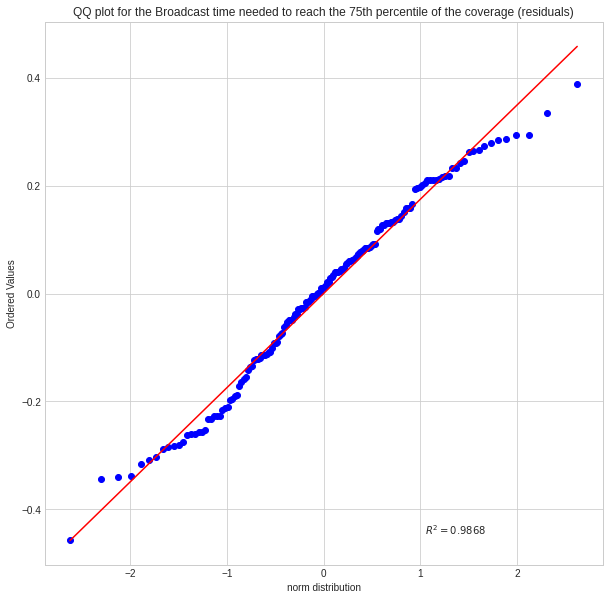

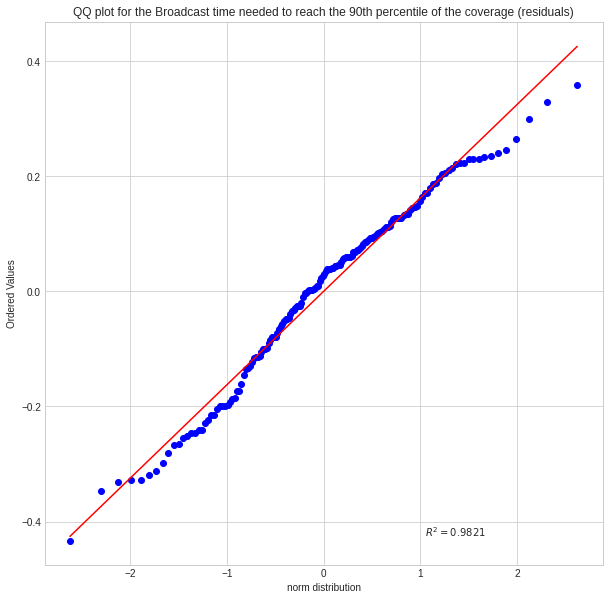

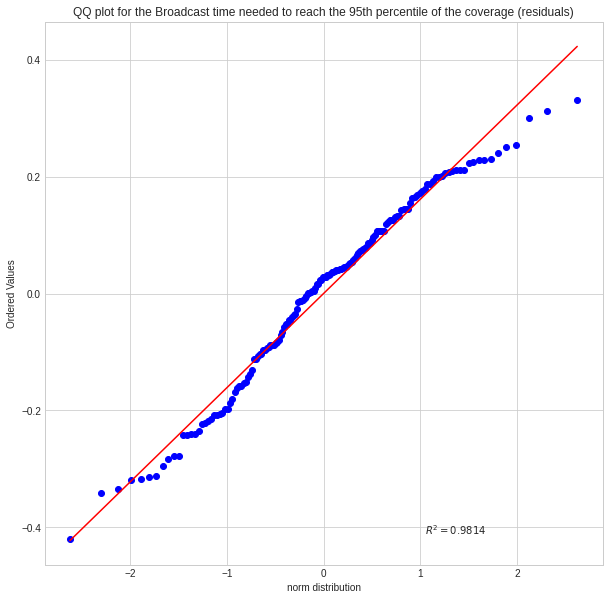

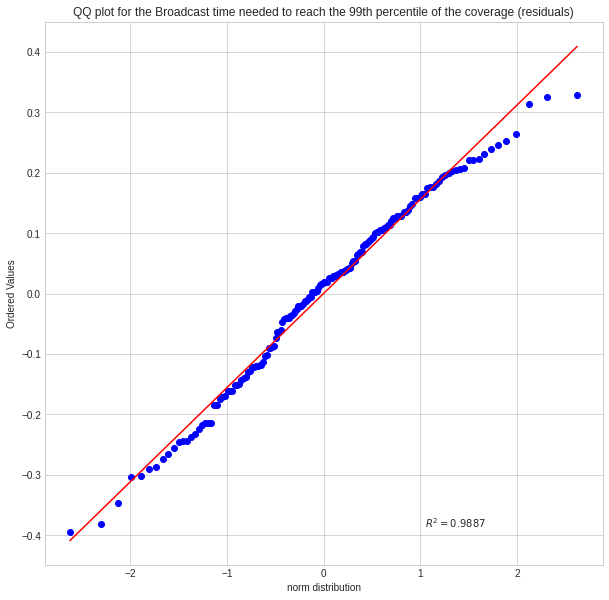

In [11]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + distribution + '-fit.png')
        plt.show()

### Notes on QQ plots

For all the indexes, except the percentage of covered users, we get "good" QQ-plots that signal a normal distribution of the residuals. The lowest R^2 index is given by the residuals of the total number of messages sent (R^2 = 0.8958) but it is still acceptable. We get this result mainly due to two outliers on the left.

The percentage of covered users has no normally distributed residuals. This is expected since, in this scenario, it is always between 99.2% and 100% and it can not go above 100%. In any case, as said in `2kr.ipynb`, we are not interested in analyzing this index in this scenario (since it is always almost perfect). So we will not talk about the percentage of covered users in the following.

### Outliers

In [12]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.999455071174377
stddev: 0.0012265418091801056
3*stddev: 0.0036796254275403167


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
HighDensity2kr-82-20210607-09:42:46-28994,4.0,2.0,10.0,10.0,2.0,5.0,-0.005605,0.998488
HighDensity2kr-84-20210607-09:43:02-28994,4.0,4.0,10.0,10.0,2.0,5.0,-0.005605,0.998488
HighDensity2kr-122-20210607-09:43:29-29099,5.0,2.0,10.0,10.0,2.0,10.0,-0.004270,0.998932
HighDensity2kr-35-20210607-09:41:15-28813,10.0,5.0,20.0,5.0,6.0,5.0,-0.004359,0.999021
HighDensity2kr-130-20210607-09:43:16-29103,13.0,0.0,20.0,10.0,2.0,10.0,-0.005160,0.998932


Outliers for the total number of collisions (residuals)
total mean: 1967.8062499999992
stddev: 133.12991952111335
3*stddev: 399.38975856334


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
HighDensity2kr-17-20210607-09:41:29-28809,8.0,7.0,20.0,5.0,2.0,5.0,-458.5,2846.5
HighDensity2kr-54-20210607-09:42:25-28915,9.0,4.0,20.0,5.0,2.0,10.0,-494.4,1899.4


Outliers for the total number of messages sent (residuals)
total mean: 873.6062500000014
stddev: 18.66128066951503
3*stddev: 55.98384200854509


qname,config,repetition,R,T,m,D,msgsPerSlotResidual,msgsPerSlotMean
run,,,,,,,,
HighDensity2kr-16-20210607-09:41:23-28809,8.0,6.0,20.0,5.0,2.0,5.0,-59.3,624.3
HighDensity2kr-54-20210607-09:42:25-28915,9.0,4.0,20.0,5.0,2.0,10.0,-96.8,624.8
HighDensity2kr-99-20210607-09:42:54-29001,12.0,9.0,20.0,10.0,2.0,5.0,66.5,497.5


Outliers for the Broadcast time needed to reach the 25th percentile of the coverage (residuals)
total mean: 3.629719337566558
stddev: 0.20023965860339088
3*stddev: 0.6007189758101726


qname,config,repetition,R,T,m,D,broadcastTime25Residual,broadcastTime25Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 50th percentile of the coverage (residuals)
total mean: 4.117411401673058
stddev: 0.1931490190894396
3*stddev: 0.5794470572683188


qname,config,repetition,R,T,m,D,broadcastTime50Residual,broadcastTime50Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 75th percentile of the coverage (residuals)
total mean: 4.418695736027464
stddev: 0.17370936182806956
3*stddev: 0.5211280854842086


qname,config,repetition,R,T,m,D,broadcastTime75Residual,broadcastTime75Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 90th percentile of the coverage (residuals)
total mean: 4.5931280024910786
stddev: 0.16189887764591482
3*stddev: 0.48569663293774445


qname,config,repetition,R,T,m,D,broadcastTime90Residual,broadcastTime90Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 95th percentile of the coverage (residuals)
total mean: 4.669222650828237
stddev: 0.16086511388565272
3*stddev: 0.48259534165695817


qname,config,repetition,R,T,m,D,broadcastTime95Residual,broadcastTime95Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 99th percentile of the coverage (residuals)
total mean: 4.782873911405891
stddev: 0.15496945411417232
3*stddev: 0.464908362342517


qname,config,repetition,R,T,m,D,broadcastTime99Residual,broadcastTime99Mean
run,,,,,,,,


## Independency test

qname,config,R,T,m,D
run,,,,,
HighDensity2kr-0-20210607-09:41:15-28806,0.0,10.0,5.0,2.0,5.0
HighDensity2kr-40-20210607-09:41:50-28892,1.0,10.0,5.0,2.0,10.0
HighDensity2kr-20-20210607-09:41:15-28810,2.0,10.0,5.0,6.0,5.0
HighDensity2kr-60-20210607-09:42:15-28957,3.0,10.0,5.0,6.0,10.0
HighDensity2kr-80-20210607-09:42:31-28994,4.0,10.0,10.0,2.0,5.0
HighDensity2kr-120-20210607-09:43:14-29099,5.0,10.0,10.0,2.0,10.0
HighDensity2kr-100-20210607-09:42:59-29063,6.0,10.0,10.0,6.0,5.0
HighDensity2kr-140-20210607-09:43:37-29147,7.0,10.0,10.0,6.0,10.0
HighDensity2kr-10-20210607-09:41:15-28808,8.0,20.0,5.0,2.0,5.0


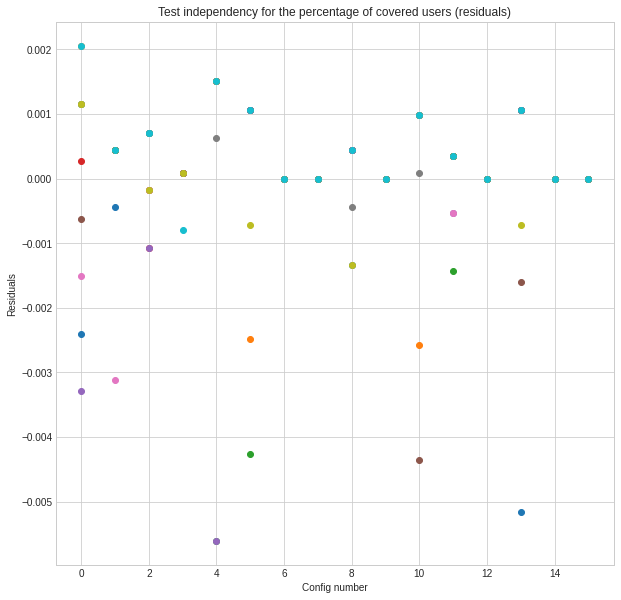

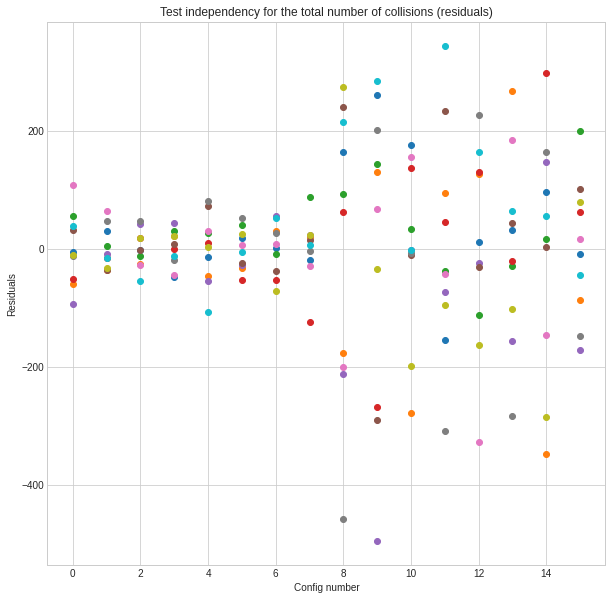

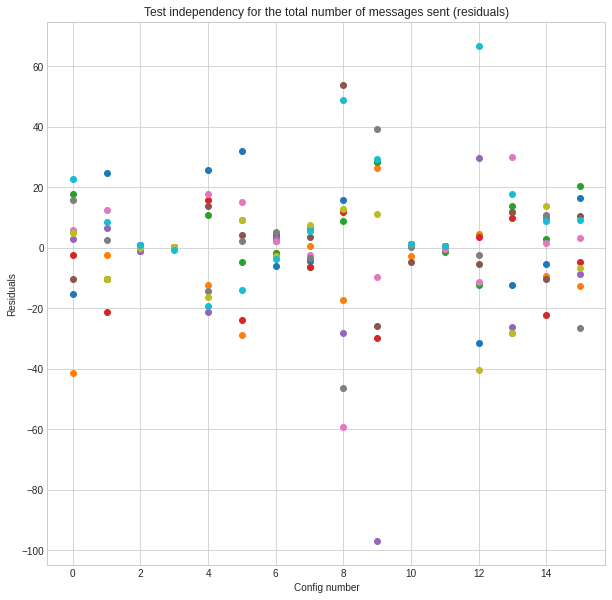

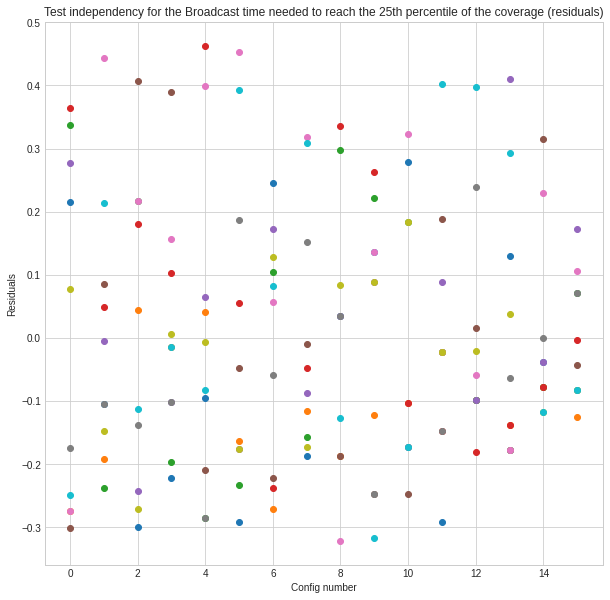

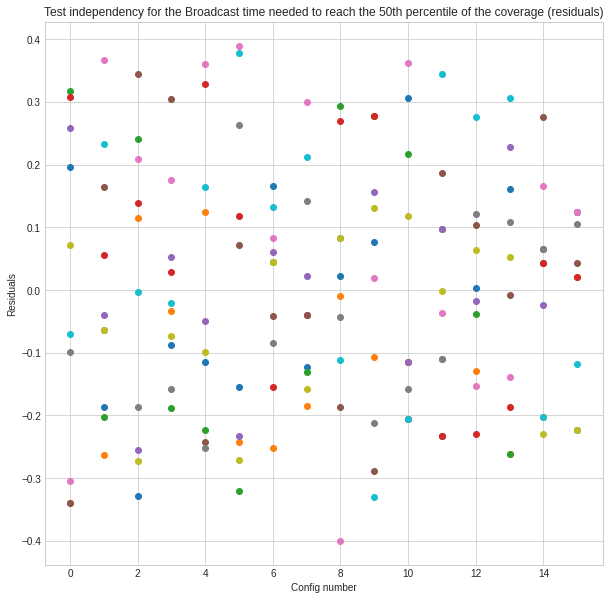

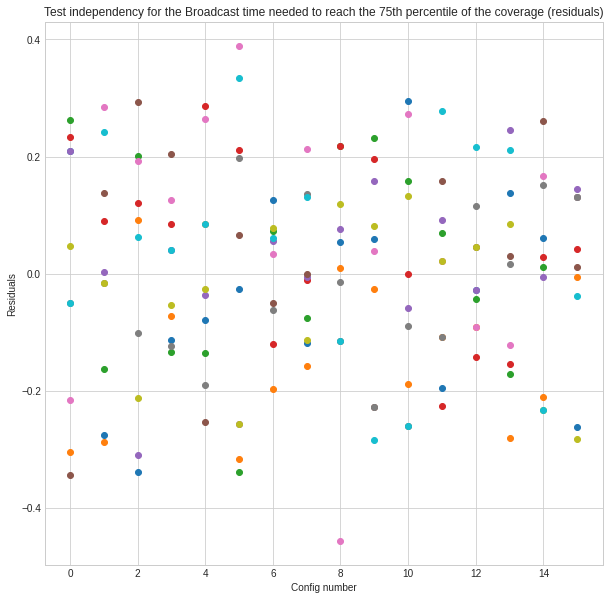

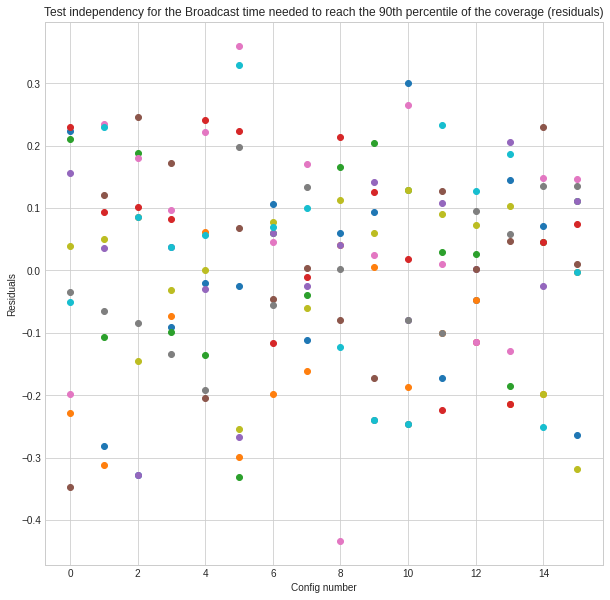

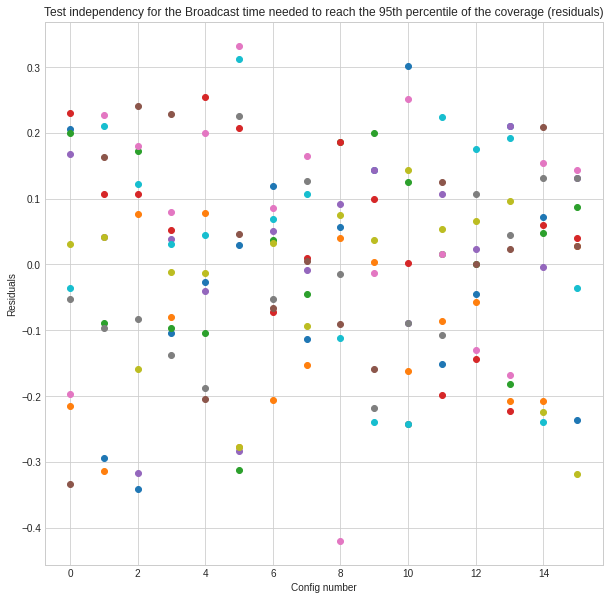

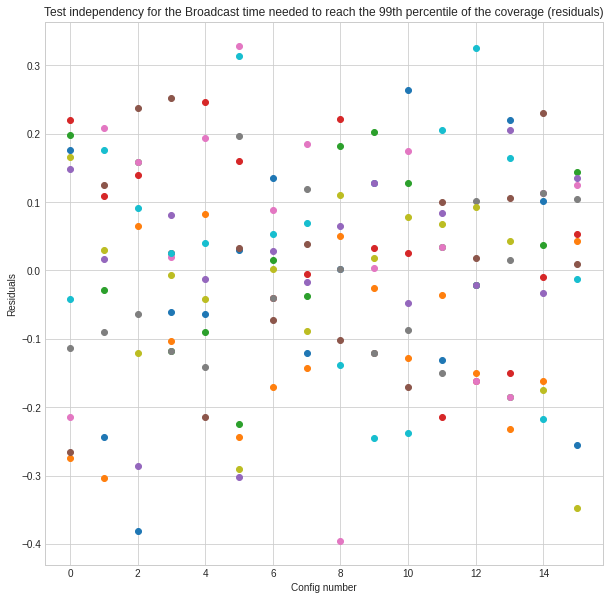

In [13]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-independency.png')
    plt.show()

### Notes on indipendency test

No trend is visible (except for the number of collisions, but this is due to the fact that experiments done with higher values of `R` are arbitrarily number with higher config numbers). We expected this result as there is no suspect of dependency between experiments by the way we have conducted the experiments.

(percentage of covered users ignored)

## Finite variance test

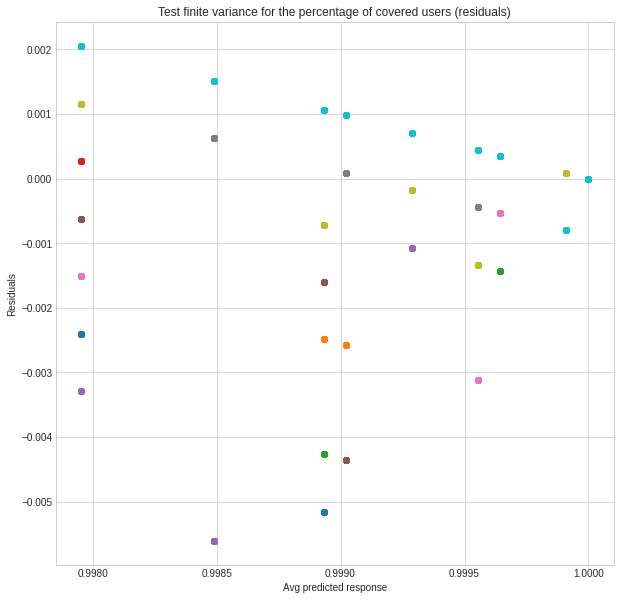

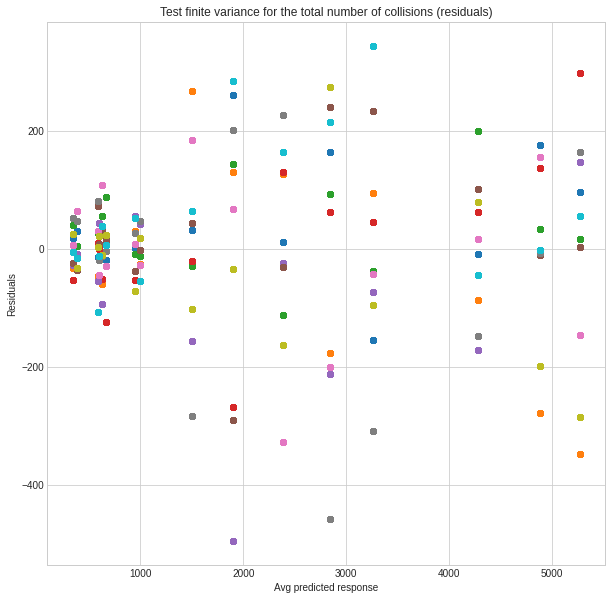

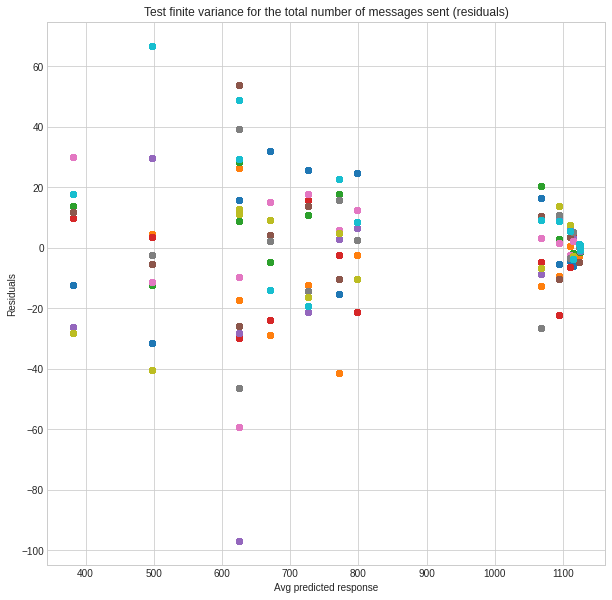

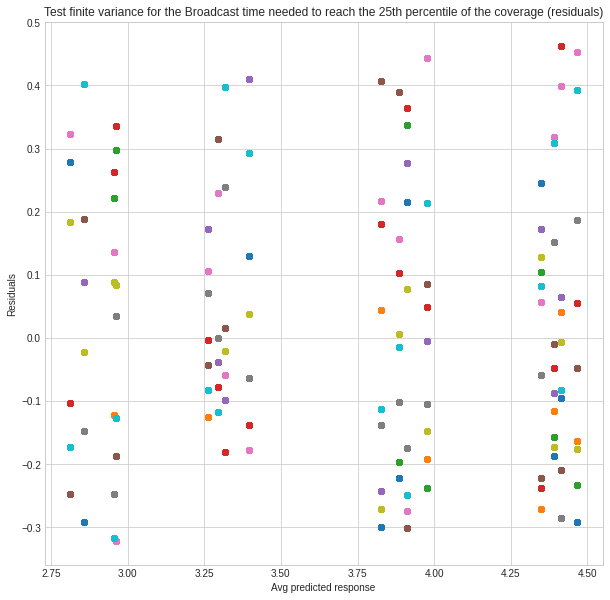

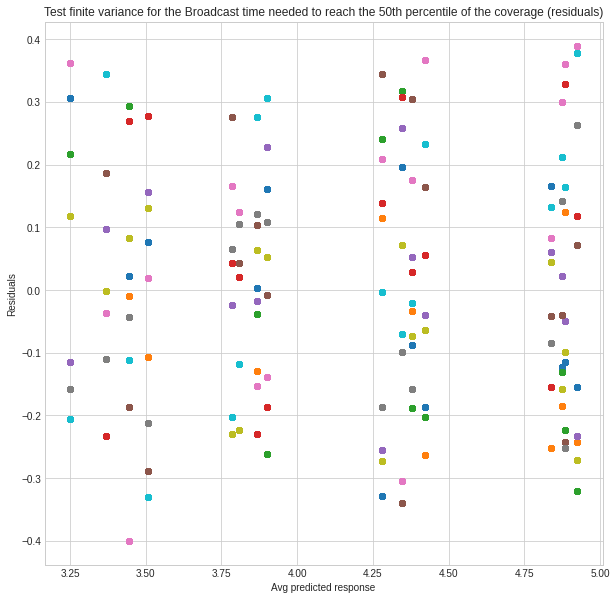

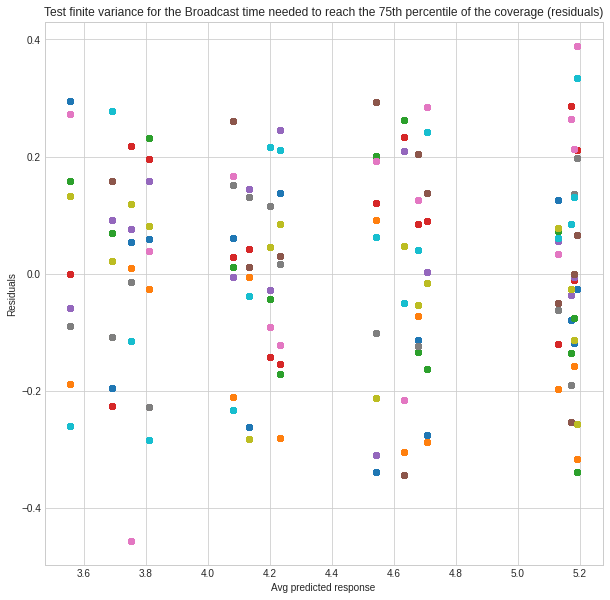

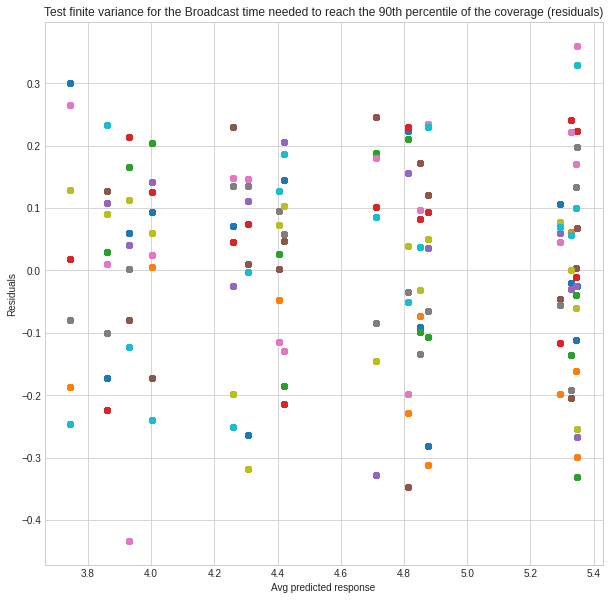

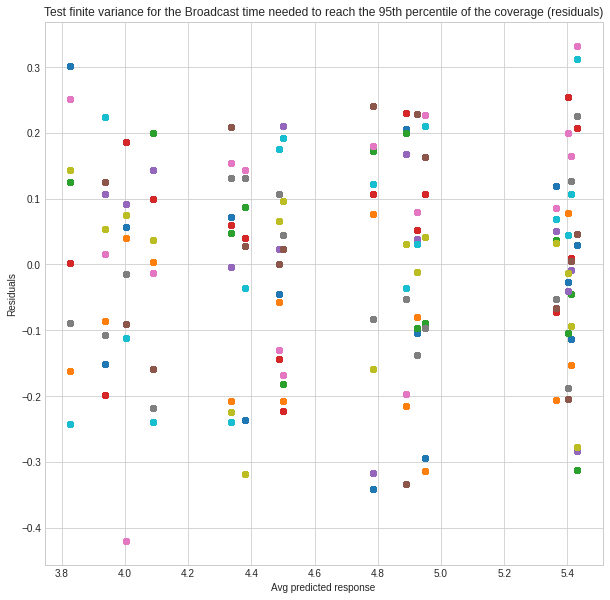

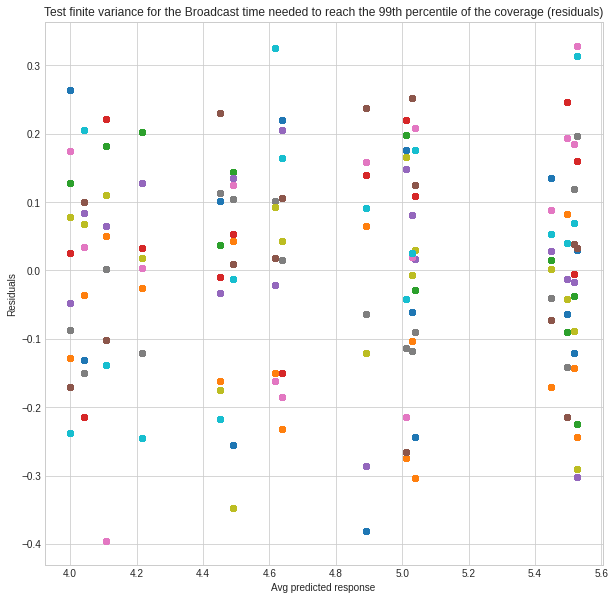

In [14]:
for varname, vardesc in residualNames:
    y = []
    x = []
    scalars_wide.sort_values([varname + 'Mean', 'repetition'], inplace=True)
    for _, row in scalars_wide.iterrows():
        config = row['config']
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-variance.png')
    plt.show()

### Notes in finite variance test

No trend is visible (also considering the difference in the order of magnitude in number of collisions and messages sent). For the broadcast time, we had to apply a logarithmic transformation of the predicted variable in order to get residuals with finite variance. Without the logarithmic trasformation, we get the plot shown in the file `2kr-assumptions-tests-notransform.ipynb`.

(percentage of covered users ignored)

### Rerun this notebook

To rerun this notebook, you can:
- just rerun the simulations with the corresponding configuration: `./simulate.sh -s HighDensity -c HighDensity2kr` (you will get slighly different results)
- download our datasets from `https://drive.google.com/file/d/1ZFRV2DecoTvax9lngEsuPPw8Cz1DXvLc/view?usp=sharing` (login with UNIPI institutional account)
- use our seed to rerun the simulations. Add `seed-set = ${runnumber}28807` to the configuration